## Import libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, r2_score, mean_squared_error

## Import data

In [2]:
#data retrive from https:lazyprogrammer.me/course_files/sp500sub.csv
df = pd.read_csv('sp500sub.csv',index_col = 'Date', parse_dates=True)

In [3]:
df.head()

,Open,High,Low,Close,Adj Close,Volume,Name
Date,,,,,,,
2010-01-04,9.22,9.51,9.17,9.50,9.50,1865400.0,INCY
2010-01-05,9.51,10.29,9.45,10.27,10.27,7608900.0,INCY
2010-01-06,10.38,11.09,10.35,11.00,11.00,8046700.0,INCY
2010-01-07,11.00,11.06,10.62,10.82,10.82,3680300.0,INCY
2010-01-08,10.82,11.00,10.75,10.94,10.94,1529300.0,INCY


## Inspecting the data

In [4]:
# Checking any missing values
df.isna().sum()

Open         7
High         7
Low          7
Close        7
Adj Close    7
Volume       7
Name         0
dtype: int64

In [5]:
# Checking all columns name available in the dataframe
print(df.columns.tolist())

['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Name']


In [6]:
# Checking all the stock prices that available
pd.set_option('display.max_rows', None)
df.Name.value_counts()

CAH     2265
NEM     2264
SLG     2264
RSG     2264
KIM     2264
INCY    2263
WU      2263
MCO     2263
CCI     2263
AZO     2263
MU      2263
VLO     2263
AIV     2263
SLB     2263
UAA     2263
CVS     2263
UAL     2263
BA      2263
FISV    2263
URI     2263
FIS     2263
WLTW    2263
GILD    2263
APH     2263
RHI     2263
VMC     2263
CB      2263
NBL     2263
CMS     2263
CBS     2263
COG     2263
GWW     2263
INTU    2263
COO     2263
ADBE    2263
ETR     2263
HBI     2263
CLX     2263
JPM     2263
MAR     2263
SNA     2263
DIS     2263
WFC     2263
ABT     2263
NEE     2263
AAP     2263
GD      2263
ACN     2263
PDCO    2263
HAS     2263
GT      2263
VNO     2263
COF     2263
MDT     2263
K       2263
UPS     2263
UNP     2263
HSIC    2263
SRE     2263
GOOG    2263
WMB     2263
HST     2263
PRU     2263
GPC     2263
AES     2263
ATVI    2263
IBM     2263
WYNN    2263
AMD     2263
ARE     2263
AFL     2263
DXC     2263
CSX     2263
MDLZ    2263
SPG     2263
IT      2263
CPB     2263

## Working out with Google stock prices

In [7]:
goog = df[df['Name'] == 'GOOG'][['Close']].copy()

In [8]:
goog.head()

,Close
Date,
2010-01-04,312.204773
2010-01-05,310.829926
2010-01-06,302.994293
2010-01-07,295.940735
2010-01-08,299.885956


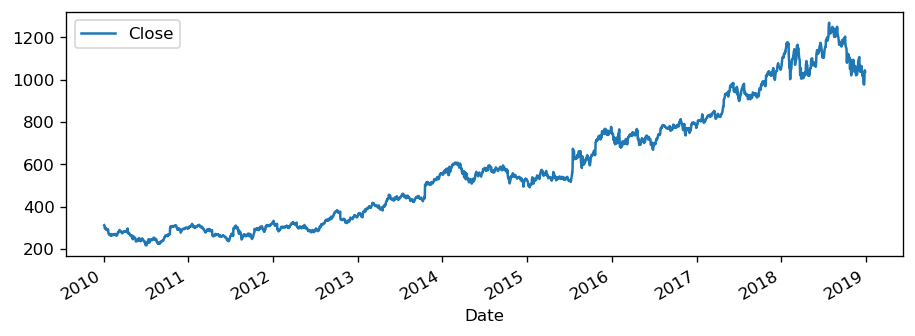

In [9]:
#Plotting the data
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})
goog.plot();

## Testing with transformations

In [10]:
goog['LogClose'] = np.log(goog['Close'])

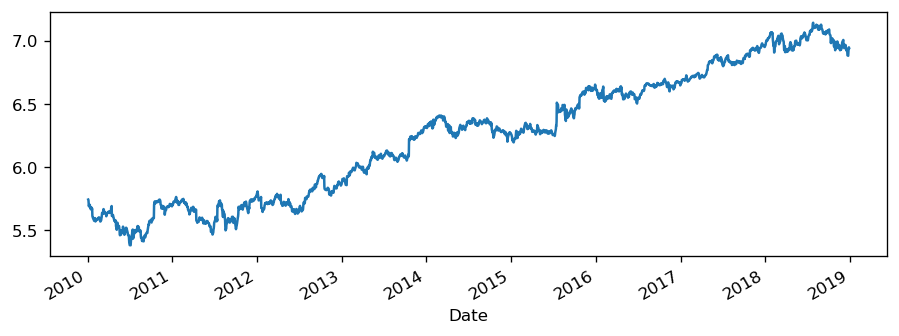

In [11]:
#Plotting the data
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})
goog['LogClose'].plot();

## Split into train and test dataset

In [12]:
goog.shape

(2263, 2)

In [13]:
# Split out the training and testing dataset
N_test = 30
train = goog.iloc[:-N_test]
test = goog.iloc[-N_test:]

In [14]:
# Boolean series to index df rows
train_idx = goog.index <= train.index[-1]
test_idx = goog.index > train.index[-1]

## Modelling using Holt Winter

In [15]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [16]:
hw = ExponentialSmoothing(train['LogClose'], 
                          initialization_method='legacy-heuristic',
                          trend = 'add',
                          seasonal = None)

C:\Users\asus\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [17]:
res_hw = hw.fit()

In [18]:
# For testing set, we have converted to numpy because not having a frequency for the index messes up the forecast indices and this well messed up where it goes in the df
goog.loc[train_idx, 'HoltWinters_Train'] = res_hw.fittedvalues
goog.loc[test_idx, 'HoltWinters_Test'] = res_hw.forecast(N_test).to_numpy()

C:\Users\asus\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


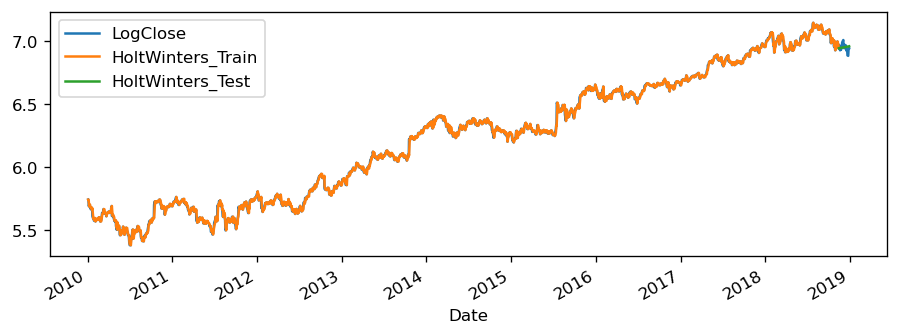

In [19]:
#Plotting the forecast data
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})
goog[['LogClose','HoltWinters_Train','HoltWinters_Test']].plot();

<AxesSubplot:xlabel='Date'>

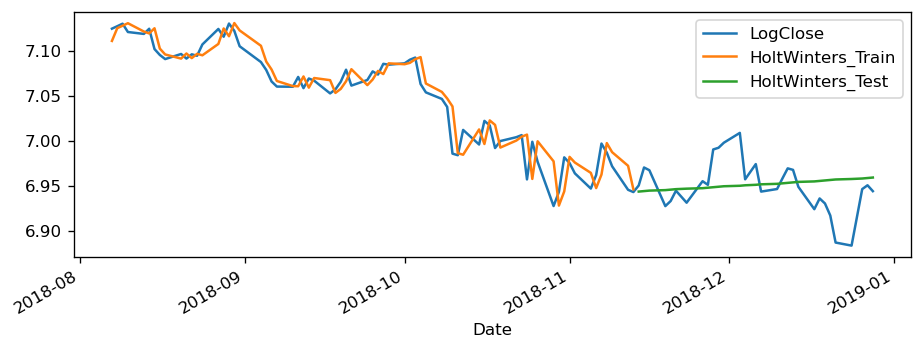

In [20]:
#Zoom in on the testing dataset
cols = ['LogClose','HoltWinters_Train','HoltWinters_Test']
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})
goog.iloc[-100:][cols].plot()

We see that our model only appears to do well on the train set because it copies the last value. This makes sense since the log price nearly follows a random walk and the forecast is straight line since we've used holts linear trend model to fit our dataset

In [21]:
def rmse(y,t):
    return np.sqrt(np.mean((y-t)**2))

In [22]:
def mae(y,t):
    return np.mean(np.abs(y-t))

In [23]:
print("Train RMSE:", rmse(goog['LogClose'], res_hw.fittedvalues))
print("Test RMSE:", rmse(goog['LogClose'], res_hw.forecast(N_test)))

Train RMSE: 0.015213712928660751
Test RMSE: nan


C:\Users\asus\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [24]:
res_hw.forecast(N_test).to_numpy()

C:\Users\asus\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


array([6.94370814, 6.94424555, 6.94478296, 6.94532036, 6.94585777,
       6.94639518, 6.94693259, 6.94747   , 6.9480074 , 6.94854481,
       6.94908222, 6.94961963, 6.95015704, 6.95069444, 6.95123185,
       6.95176926, 6.95230667, 6.95284408, 6.95338148, 6.95391889,
       6.9544563 , 6.95499371, 6.95553112, 6.95606853, 6.95660593,
       6.95714334, 6.95768075, 6.95821816, 6.95875557, 6.95929297])

Since the forecast value is in array we will make this as a dataframe and match with the testing index

In [35]:
test

,Close,LogClose
Date,,
2018-11-14,1043.660034,6.950489
2018-11-15,1064.709961,6.970458
2018-11-16,1061.489990,6.967429
2018-11-19,1020.000000,6.927558
2018-11-20,1025.760010,6.933189
2018-11-21,1037.609985,6.944675
2018-11-23,1023.880005,6.931355
2018-11-26,1048.619995,6.955230
2018-11-27,1044.410034,6.951207


In [37]:
test1 = test[['LogClose']].copy().reset_index()

In [38]:
test1

,Date,LogClose
0,2018-11-14,6.950489
1,2018-11-15,6.970458
2,2018-11-16,6.967429
3,2018-11-19,6.927558
4,2018-11-20,6.933189
5,2018-11-21,6.944675
6,2018-11-23,6.931355
7,2018-11-26,6.955230
8,2018-11-27,6.951207
9,2018-11-28,6.990468


In [39]:
test_forecast = res_hw.forecast(N_test).to_numpy()

C:\Users\asus\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [40]:
test_forecast

array([6.94370814, 6.94424555, 6.94478296, 6.94532036, 6.94585777,
       6.94639518, 6.94693259, 6.94747   , 6.9480074 , 6.94854481,
       6.94908222, 6.94961963, 6.95015704, 6.95069444, 6.95123185,
       6.95176926, 6.95230667, 6.95284408, 6.95338148, 6.95391889,
       6.9544563 , 6.95499371, 6.95553112, 6.95606853, 6.95660593,
       6.95714334, 6.95768075, 6.95821816, 6.95875557, 6.95929297])

In [46]:
column = ['LogPrice_HoltWinters']
forecast = pd.DataFrame(test_forecast, columns=column)
test1 = test1.join(forecast)

In [47]:
test1

,Date,LogClose,LogPrice_HoltWinters
0,2018-11-14,6.950489,6.943708
1,2018-11-15,6.970458,6.944246
2,2018-11-16,6.967429,6.944783
3,2018-11-19,6.927558,6.945320
4,2018-11-20,6.933189,6.945858
5,2018-11-21,6.944675,6.946395
6,2018-11-23,6.931355,6.946933
7,2018-11-26,6.955230,6.947470
8,2018-11-27,6.951207,6.948007
9,2018-11-28,6.990468,6.948545


In [48]:
#Set to index
test1 = test1.set_index('Date')

In [49]:
test1.head()

,LogClose,LogPrice_HoltWinters
Date,,
2018-11-14,6.950489,6.943708
2018-11-15,6.970458,6.944246
2018-11-16,6.967429,6.944783
2018-11-19,6.927558,6.945320
2018-11-20,6.933189,6.945858


In [50]:
y_true = test1.iloc[1:]['LogClose']
y_pred = test1.iloc[1:]['LogPrice_HoltWinters']

In [51]:
#RMSE
mean_squared_error(y_true,y_pred, squared=False)

0.030486998369675347

In [52]:
#MAE
mean_absolute_error(y_true,y_pred)

0.02339791937787056

In [53]:
#Rsquared
r2_score(y_true,y_pred)

-0.15679479449488176

## Modelling using Naive

In [59]:
goog.loc[test_idx,'Naive'] = train.iloc[-1]['LogClose']

In [61]:
goog.tail(35)

,Close,LogClose,HoltWinters_Train,HoltWinters_Test,ClosePrediction,Naive
Date,,,,,,
2018-11-07,1093.390015,6.997038,6.962601,NaN,6.962064,NaN
2018-11-08,1082.400024,6.986936,6.997576,NaN,6.997038,NaN
2018-11-09,1066.150024,6.971809,6.987474,NaN,6.986936,NaN
2018-11-12,1038.630005,6.945658,6.972347,NaN,6.971809,NaN
2018-11-13,1036.050049,6.943171,6.946195,NaN,6.945658,NaN
2018-11-14,1043.660034,6.950489,NaN,6.943708,6.943171,6.943171
2018-11-15,1064.709961,6.970458,NaN,6.944246,6.950489,6.943171
2018-11-16,1061.489990,6.967429,NaN,6.944783,6.970458,6.943171
2018-11-19,1020.000000,6.927558,NaN,6.945320,6.967429,6.943171


<AxesSubplot:xlabel='Date'>

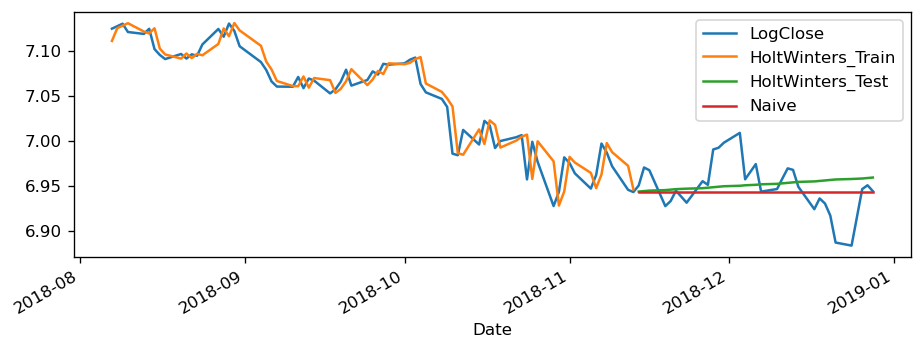

In [62]:
cols = ['LogClose','HoltWinters_Train','HoltWinters_Test','Naive']
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})
goog.iloc[-100:][cols].plot()

In [67]:
goog.tail(30)

,Close,LogClose,HoltWinters_Train,HoltWinters_Test,ClosePrediction,Naive
Date,,,,,,
2018-11-14,1043.660034,6.950489,NaN,6.943708,6.943171,6.943171
2018-11-15,1064.709961,6.970458,NaN,6.944246,6.950489,6.943171
2018-11-16,1061.489990,6.967429,NaN,6.944783,6.970458,6.943171
2018-11-19,1020.000000,6.927558,NaN,6.945320,6.967429,6.943171
2018-11-20,1025.760010,6.933189,NaN,6.945858,6.927558,6.943171
2018-11-21,1037.609985,6.944675,NaN,6.946395,6.933189,6.943171
2018-11-23,1023.880005,6.931355,NaN,6.946933,6.944675,6.943171
2018-11-26,1048.619995,6.955230,NaN,6.947470,6.931355,6.943171
2018-11-27,1044.410034,6.951207,NaN,6.948007,6.955230,6.943171


In [71]:
y_true1 = goog.iloc[-30:]['LogClose']
y_pred1 = goog.iloc[-30:]['Naive']

In [73]:
#RMSE
mean_squared_error(y_true1,y_pred1, squared=False)

0.028754567740846233

In [74]:
#MAE
mean_absolute_error(y_true1,y_pred1)

0.021602034616821766

In [75]:
#Rsquared
r2_score(y_true1,y_pred1)

-0.06454209862026317